# public functions

In [2]:
import os
import numpy as np
import pandas as pd
from functools import lru_cache
from collections import Counter, defaultdict
from tqdm import trange, tqdm
import copy

In [3]:
train_data_dir = '../raw_data/'
test_data_dir = '../raw_data/'

In [4]:
@lru_cache(maxsize=1)
def read_product_data():
    print(os.getcwd())
    print(os.path.join(train_data_dir, 'products_train.csv'))
    return pd.read_csv(os.path.join(train_data_dir, 'products_train.csv'))

In [5]:
products = read_product_data()
products.head(2)

/root/autodl-tmp/xiaolong/WorkSpace/Amazon-KDDCUP-23/data_preprocess
../raw_data/products_train.csv


,id,locale,title,price,brand,color,size,model,material,author,desc
0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.95,RED DRAGON,NaN,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.90,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...


In [6]:
processed_products = copy.deepcopy(products)

In [ ]:
if not os.path.exists('../data_for_recstudio/'):
    os.makedirs('../data_for_recstudio/')
    os.makedirs('../data_for_recstudio/task1_data')
    os.makedirs('../data_for_recstudio/DE_data')
    os.makedirs('../data_for_recstudio/JP_data')
    os.makedirs('../data_for_recstudio/UK_data')
    os.makedirs('../data_for_recstudio/ES_data')
    os.makedirs('../data_for_recstudio/FR_data')
    os.makedirs('../data_for_recstudio/IT_data')

# Color

In [6]:
def lower_color(x):
    if not pd.isna(x):
        return x.lower()
    else:
        return x

In [7]:
def split_color(x):
    if '/' in x:
        res = x.split('/')
    elif ',' in x:
        res = x.split(',')
    elif ' ' in x:
        res = x.split(' ')
    else:
        res = [x]
    return [_.strip(' ') for _ in res]

In [8]:
def precess_color(products_df, color_set):
    new_color_col = []
    for i in tqdm(products_df.index, total=len(products_df)):
        cur_color = products_df.loc[i, 'color']
        if pd.isna(cur_color):
            new_color_col.append(cur_color)
        else:
            if cur_color in color_set:
                new_color_col.append(cur_color)
            else:
                in_color_list = []
                cur_color_sep = split_color(cur_color)
                for c in cur_color_sep:
                    if c in color_set:
                        in_color_list.append(c)
                if len(in_color_list) == 0:
                    new_color_col.append(float('nan'))
                else:
                    new_color_col.append('|'.join(in_color_list))
    products_df['processed_color'] = new_color_col

In [9]:
products['color'] = products['color'].apply(lower_color)

In [10]:
products.head(5)

,id,locale,title,price,brand,color,size,model,material,author,desc
0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.95,RED DRAGON,NaN,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.90,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...
2,B09MBZJ48V,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.89,Sennheiser,multi-colour,One size,508377,Kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...
3,B08ZN6F26S,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.99,Amy & Benton,animal car,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...
4,B094DGRV7D,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.17,PLAYMOBIL,nicht zutreffend.,OneSize,70522,Polypropylen,NaN,Inhalt: 1 Stück


In [11]:
processed_products['processed_color'] = [float('nan') for i in range(len(processed_products))]

In [12]:
def process_color_for_locale(locale_name):
    cur_products = products[products['locale'] == locale_name]
    print("============print color infomation===============")
    print(f"unique : {len(cur_products['color'].unique())}, not na : {cur_products['color'].notna().sum()}, share number : {cur_products['color'].notna().sum() / len(cur_products['color'].unique())}")
    
    # color share counter 
    print("============start to get color share counter===============")
    cur_color_share_counter = Counter()
    cur_color_share_set = defaultdict(list)
    for i in tqdm(cur_products.index, total=len(cur_products.index)):
        product_id = cur_products.loc[i, 'id']
        product_color = cur_products.loc[i, 'color']
        if (not pd.isna(product_color)) and (product_id not in cur_color_share_set[product_color]):
            cur_color_share_counter[product_color] += 1
            cur_color_share_set[product_color].append(product_id)
    colors_150, nums_150 = zip(*cur_color_share_counter.most_common(150))
    print("=============most 10 popular colors===============")
    print(colors_150[:10])
    
    # cover ratio of 150 colors
    print("=============cover ratio of 150 colors===============")
    single_color_num = 0
    for k in cur_color_share_counter.keys():
        if cur_color_share_counter[k] == 1:
            single_color_num += 1
    print(np.array(nums_150).sum(), np.array(nums_150).sum() / cur_products['color'].notna().sum(), (np.array(nums_150).sum() + single_color_num) / cur_products['color'].notna().sum())
    
    print("=============process colors===============")
    precess_color(cur_products, colors_150)
    
    processed_products[processed_products['locale'] == locale_name] = cur_products
    

In [13]:
process_color_for_locale('DE')
process_color_for_locale('JP')
process_color_for_locale('UK')

============print color infomation===============
unique : 78391, not na : 391466, share number : 4.99376203900958
============start to get color share counter===============


100%|██████████| 518327/518327 [03:17<00:00, 2624.69it/s] 


=============most 10 popular colors===============
('schwarz', 'weiß', 'mehrfarbig', 'blau', 'grau', 'silber', 'rot', 'grün', 'transparent', 'braun')
=============cover ratio of 150 colors===============
242476 0.6194050057987156 0.7769257100233481
=============process colors===============


100%|██████████| 518327/518327 [00:08<00:00, 63094.01it/s]
/tmp/ipykernel_457914/607710257.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_df['processed_color'] = new_color_col


============print color infomation===============
unique : 53480, not na : 252934, share number : 4.729506357516828
============start to get color share counter===============


100%|██████████| 395009/395009 [00:55<00:00, 7125.33it/s] 


=============most 10 popular colors===============
('ブラック', 'ホワイト', 'グレー', 'シルバー', 'ブルー', 'ピンク', '黒', 'ブラウン', 'グリーン', '白')
=============cover ratio of 150 colors===============
156291 0.6179121826247164 0.7823305684486862
=============process colors===============


100%|██████████| 395009/395009 [00:06<00:00, 60383.26it/s]
/tmp/ipykernel_457914/607710257.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_df['processed_color'] = new_color_col


============print color infomation===============
unique : 68935, not na : 378080, share number : 5.484586929716399
============start to get color share counter===============


100%|██████████| 500180/500180 [03:22<00:00, 2467.68it/s]


=============most 10 popular colors===============
('black', 'white', 'blue', 'grey', 'silver', 'multicolor', 'red', 'pink', 'green', 'clear')
=============cover ratio of 150 colors===============
247601 0.6548904993652137 0.800089928057554
=============process colors===============


100%|██████████| 500180/500180 [00:07<00:00, 67141.14it/s]
/tmp/ipykernel_457914/607710257.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_df['processed_color'] = new_color_col


In [14]:
process_color_for_locale('IT')
process_color_for_locale('FR')
process_color_for_locale('ES')

============print color infomation===============
unique : 8624, not na : 36068, share number : 4.182282003710575
============start to get color share counter===============


100%|██████████| 50461/50461 [00:02<00:00, 24708.67it/s]


=============most 10 popular colors===============
('nero', 'bianco', 'multicolore', 'blu', 'grigio', 'trasparente', 'argento', 'black', 'verde', 'rosso')
=============cover ratio of 150 colors===============
23706 0.657258511700122 0.8460408117999335
=============process colors===============


100%|██████████| 50461/50461 [00:00<00:00, 60186.31it/s]
/tmp/ipykernel_457914/607710257.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_df['processed_color'] = new_color_col


============print color infomation===============
unique : 8255, not na : 33996, share number : 4.118231374924289
============start to get color share counter===============


100%|██████████| 44577/44577 [00:01<00:00, 24090.93it/s]


=============most 10 popular colors===============
('noir', 'blanc', 'multicolore', 'bleu', 'gris', 'transparent', 'rose', 'rouge', 'black', 'argent')
=============cover ratio of 150 colors===============
22593 0.6645781856689023 0.8601306036004236
=============process colors===============


100%|██████████| 44577/44577 [00:00<00:00, 65709.83it/s]
/tmp/ipykernel_457914/607710257.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_df['processed_color'] = new_color_col


============print color infomation===============
unique : 7425, not na : 32888, share number : 4.429360269360269
============start to get color share counter===============


100%|██████████| 42503/42503 [00:01<00:00, 26901.00it/s]


=============most 10 popular colors===============
('negro', 'blanco', 'multicolor', 'azul', 'gris', 'transparente', 'verde', 'rojo', 'black', 'rosa')
=============cover ratio of 150 colors===============
22719 0.6907990756506933 0.8711688153733884
=============process colors===============


100%|██████████| 42503/42503 [00:00<00:00, 56961.40it/s]
/tmp/ipykernel_457914/607710257.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_df['processed_color'] = new_color_col


In [15]:
processed_products.drop(columns=['color'], inplace=True)

In [16]:
processed_products

,id,locale,title,price,brand,size,model,material,author,desc,processed_color
0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.95,RED DRAGON,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...,NaN
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.90,Simply Keto,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...,NaN
2,B09MBZJ48V,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.89,Sennheiser,One size,508377,Kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...,NaN
3,B08ZN6F26S,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.99,Amy & Benton,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...,NaN
4,B094DGRV7D,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.17,PLAYMOBIL,OneSize,70522,Polypropylen,NaN,Inhalt: 1 Stück,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1551052,B09BW5CDRR,IT,Barbie - Playset Gelateria con Bambola con Mac...,20.48,Barbie,NaN,HCN46,NaN,NaN,DETTAGLI REALISTICI. Basta inserire la pasta m...,NaN
1551053,B0050IILBM,IT,"Braun Silk-épil 1 Depilatore Donna, Epilatore ...",22.61,Braun,NaN,4210201656067,NaN,NaN,Alimentato a corrente per un comodo utilizzo,pink
1551054,B07W4C5W9D,IT,BoxLegend Sacchetti Sottovuoto Vestiti 6 Pezzi...,14.99,BoxLegend,6 Pezzi (2L + 2M + 2S),6186666487608_SML,Polietilene Ppa,NaN,6 Sacchetti in 3 Diverse Misure- Questo set di...,NaN
1551055,B012D0HJXA,IT,Trasportino Pratiko Metal - Accessorio da viag...,18.35,MPS,NaN,NaN,Metallo,NaN,TRASPORTINO 48X31.5X33CM,verde


In [17]:
processed_products.to_csv('../data_for_recstudio/processed_products_train.csv', index=False)

# price 

In [45]:
processed_products = pd.read_csv('../data_for_recstudio/processed_products_train.csv')

In [18]:
processed_products.head(10)

,id,locale,title,price,brand,size,model,material,author,desc,processed_color
0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.95,RED DRAGON,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...,NaN
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.90,Simply Keto,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...,NaN
2,B09MBZJ48V,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.89,Sennheiser,One size,508377,Kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...,NaN
3,B08ZN6F26S,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.99,Amy & Benton,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...,NaN
4,B094DGRV7D,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.17,PLAYMOBIL,OneSize,70522,Polypropylen,NaN,Inhalt: 1 Stück,NaN
5,B09JNNBDH5,DE,"URBZUE Handwärmer, 10000mAh USB aufladbar und ...",20.99,URBZUE,13.5*9*5,Oro rosa,Aluminium,NaN,Einstellbarer Temperaturmodus: Aufladbare Hand...,NaN
6,B08R62WZ1Y,DE,"Kinderkopfhörer Bluetooth, Mädchen Katzenohr K...",24.97,JYPS,NaN,Kinderkopfhörer,NaN,NaN,🎁Drahtlose und kabelgebundene Kinderkopfhörer:...,lila
7,B09WK4YNX8,DE,"8 Stück Herd Schalter Schutz, Küche Gasherd Kn...",12.49,FANSEZQ,NaN,NaN,NaN,NaN,【BREITE ANWENDUNG】Diese Knopfschutzabdeckung i...,transparent
8,B07KTKFYYS,DE,AVANA Edelstahl Ausstechformen 12 Stück Ringe ...,13.99,AVANA,NaN,NaN,Edelstahl,NaN,100% ZUFRIEDENHEITSGARANTIE - Falls Sie nicht ...,silber
9,B0B9MPKYJK,DE,Amstory Stirnlampe LED Wiederaufladbar Joggen ...,25.99,Amstory,2 Stücke,LMHL-0006BK,ABS,NaN,☀【1000 Lumen Superheller Kopflampe】 Der LED He...,schwarz


In [19]:
def replace_invalid_price(locale_name):
    locale_price_mean = products[products['locale'] == locale_name]['price'].apply(lambda x : x if x != 40000000.07 else 0.0).mean()
    processed_products.loc[(products['locale'] == locale_name) & (products['price'] == 40000000.07), 'price'] = locale_price_mean
    print(f'The mean price of {locale_name} is {locale_price_mean}!')

In [20]:
replace_invalid_price('DE')
replace_invalid_price('JP')
replace_invalid_price('UK')
replace_invalid_price('IT')
replace_invalid_price('FR')
replace_invalid_price('ES')

The mean price of DE is 36.7616060903638!
The mean price of JP is 4201.2729840839065!
The mean price of UK is 22.097065056579634!
The mean price of IT is 41.40211192802362!
The mean price of FR is 36.92596899746506!
The mean price of ES is 40.18674375926405!


In [21]:
processed_products[(products['locale'] == 'JP') & (products['price'] == 40000000.07)]

,id,locale,title,price,brand,size,model,material,author,desc,processed_color
518393,B00A3PNT2S,JP,アール【すりガラス対応】 【日本製】 【結露対策】 すりガラス用結露吸水テープ トナカイ H...,4201.272984,アール,NaN,H-281,PET,NaN,サイズ:8*180*0.3㎝,ホワイト
518401,B07G2L16ZK,JP,[東京下町工房] 本革コインケース 小銭入れ 完全手作り 手縫い仕上げ コンパクト 使いやす...,4201.272984,東京下町工房,Medium,0917,レザー,NaN,【完全手作り】 完全手作りで一つひとつ人の手により、丁寧に仕上げられています。シンプルで高級...,ブラック
518443,B07SHBFG97,JP,N NEWKOIN 【最新強化版】 室内 HD テレビ アンテナ地デジアンテナ 卓上 TV ...,4201.272984,N NEWKOIN,SW003,NaN,NaN,NaN,【購入する前に読んでください】このアンテナを購入する前に、近くに信号塔があることを確認してく...,blue
518451,B0B615DW5G,JP,イヌノカガヤキニチジョウヘン,4201.272984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518474,B0B9NG2KQ8,JP,ハロウィン 飾り付け 風船 バルーン 装飾セット パーティー イベント HAPPY HALL...,4201.272984,Xinvery,NaN,X0002,紙吹雪,NaN,【 楽しく飾りつけ】初心者＆自信がない方でもスムーズにご準備できます。素敵なガーランドが作り...,b
...,...,...,...,...,...,...,...,...,...,...,...
913248,B00D0X3KH4,JP,【正規品】 Herman Miller (ハーマンミラー) セイルチェア オフィスチェア グ...,4201.272984,HermanMiller(ハーマンミラー),巾73x奥行73ｘ高さ89~99,AS1YA23HA N2 65 BB SG SG 7314,アルミニウム,NaN,「設置・組立・引き取り」サービスを一部地域でご利用いただけます。本ページ内に「サービスオプシ...,グレー
913274,B0B2RMRNFH,JP,くらしモアさぬき丸一製麺 本場熟成さぬきうどん 5食入,4201.272984,くらしモアさぬき丸一製麺,NaN,NaN,NaN,NaN,冷凍,NaN
913289,B07Y8HG5F7,JP,CINECE ハロウィン 飾り コウモリ ステッカー 108枚セット PVC製 立体 取り外...,4201.272984,CINECE,NaN,NaN,ポリ塩化ビニル,NaN,付属の両面シールを胴体部分に貼って壁に貼り付ける仕様になります。,NaN
913299,B0BCWJK33Y,JP,フック 壁 傷つけない 耐荷重5kg (3個入り) 石膏ボード 壁紙 賃貸 ホチキスで取付 ...,4201.272984,ウエルスジャパン(Wealth JAPAN),‎縦5.2×横3×厚さ2cm,NaN,NaN,NaN,壁面の有効利用で・お部屋がスッキリ!,ホワイト


In [22]:
processed_products['price'] = np.log1p(processed_products['price'])

In [23]:
processed_products.to_csv('../data_for_recstudio/processed_products_train.csv', index=False)

# brand

In [24]:
def lower_name(x):
    if not pd.isna(x):
        return x.lower()
    else:
        return x

In [25]:
products['brand'] = products['brand'].apply(lambda x : lower_name(x))

In [26]:
def locale_brand_statistic(locale_name):
    locale_products = products[products['locale'] == locale_name]
    # color share counter 
    brand_counter = Counter()
    for i in tqdm(locale_products.index, total=locale_products.shape[0]):
        product_id = locale_products.loc[i, 'id']
        product_brand = locale_products.loc[i, 'brand']
        if not pd.isna(product_brand):
            brand_counter[product_brand] += 1
    
    single_brand_num = 0
    for k in brand_counter.keys():
        if brand_counter[k] == 1:
            single_brand_num += 1
    print(f"The number of all brand : {len(brand_counter.keys())}, the number of single brands : {single_brand_num}.")
    return brand_counter

In [27]:
DE_brand_counter = locale_brand_statistic('DE')

100%|██████████| 518327/518327 [00:12<00:00, 40434.45it/s]

The number of all brand : 68940, the number of single brands : 25486.


In [28]:
JP_brand_counter = locale_brand_statistic('JP')
UK_brand_counter = locale_brand_statistic('UK')

100%|██████████| 395009/395009 [00:10<00:00, 38323.24it/s]


The number of all brand : 48697, the number of single brands : 18183.


100%|██████████| 500180/500180 [00:12<00:00, 38523.46it/s]


The number of all brand : 72755, the number of single brands : 27977.


In [29]:
most_brands, most_nums = zip(*DE_brand_counter.most_common(10000))

x, y is got.


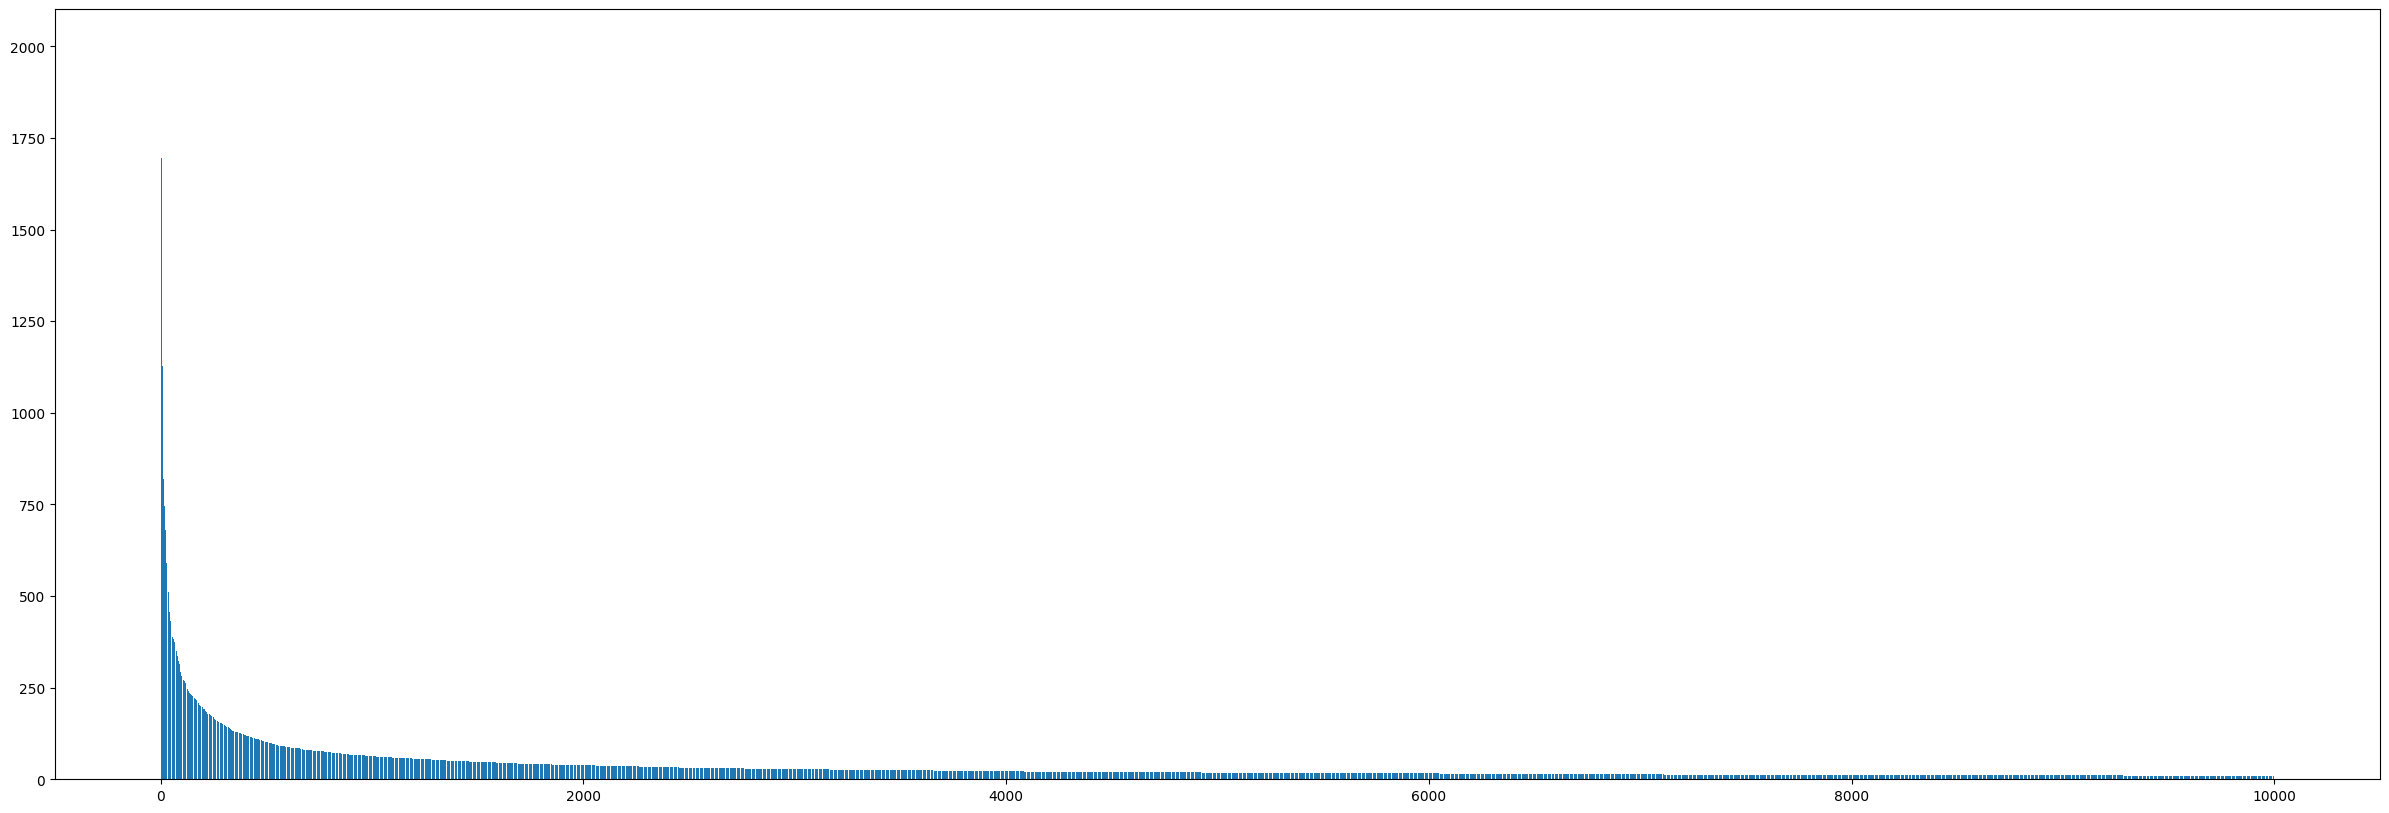

In [30]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(30, 10))

x = np.array(range(len(most_brands)))
y = np.array(list(most_nums))
print('x, y is got.')

plt.bar(x,y)
plt.show()

In [31]:
processed_products['brand'] = processed_products['brand'].apply(lambda x : lower_name(x))

# material

In [32]:
products['material'] = products['material'].apply(lambda x : lower_name(x))

In [33]:
def locale_material_statistic(locale_name):
    locale_products = products[products['locale'] == locale_name]
    # color share counter 
    brand_counter = Counter()
    for i in tqdm(locale_products.index, total=locale_products.shape[0]):
        product_id = locale_products.loc[i, 'id']
        product_material = locale_products.loc[i, 'material']
        if not pd.isna(product_material):
            brand_counter[product_material] += 1
    
    single_brand_num = 0
    for k in brand_counter.keys():
        if brand_counter[k] == 1:
            single_brand_num += 1
    print(f"The number of all brand : {len(brand_counter.keys())}, the number of single brands : {single_brand_num}.")
    return brand_counter

In [34]:
DE_brand_counter = locale_material_statistic('DE')
JP_brand_counter = locale_material_statistic('JP')
UK_brand_counter = locale_material_statistic('UK')

100%|██████████| 518327/518327 [00:12<00:00, 40148.09it/s]


The number of all brand : 15126, the number of single brands : 8992.


100%|██████████| 395009/395009 [00:09<00:00, 39942.61it/s]


The number of all brand : 15407, the number of single brands : 9024.


100%|██████████| 500180/500180 [00:12<00:00, 39710.51it/s]


The number of all brand : 13609, the number of single brands : 7989.


In [35]:
processed_products['material'] = processed_products['material'].apply(lambda x : lower_name(x))

# author

In [36]:
products['author'] = products['author'].apply(lambda x : lower_name(x))

In [37]:
def locale_author_statistic(locale_name):
    locale_products = products[products['locale'] == locale_name]
    # color share counter 
    author_counter = Counter()
    for i in tqdm(locale_products.index, total=locale_products.shape[0]):
        product_id = locale_products.loc[i, 'id']
        product_author = locale_products.loc[i, 'author']
        if not pd.isna(product_author):
            author_counter[product_author] += 1
    
    single_author_num = 0
    for k in author_counter.keys():
        if author_counter[k] == 1:
            single_author_num += 1
    print(f"The number of all brand : {len(author_counter.keys())}, the number of single brands : {single_author_num}.")
    return author_counter

In [38]:
DE_material_counter = locale_material_statistic('DE')
JP_material_counter = locale_material_statistic('JP')
UK_material_counter = locale_material_statistic('UK')

100%|██████████| 518327/518327 [00:12<00:00, 40240.31it/s]


The number of all brand : 15126, the number of single brands : 8992.


100%|██████████| 395009/395009 [00:09<00:00, 40859.65it/s]


The number of all brand : 15407, the number of single brands : 9024.


100%|██████████| 500180/500180 [00:12<00:00, 39870.68it/s]


The number of all brand : 13609, the number of single brands : 7989.


In [39]:
processed_products['author'] = processed_products['author'].apply(lambda x : lower_name(x))

In [40]:
processed_products.to_csv('../data_for_recstudio/processed_products_train.csv', index=False)

In [41]:
UK_processed_products = processed_products[processed_products['locale'] == 'UK']
UK_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
UK_processed_products.to_csv('../data_for_recstudio/UK_data/UK_processed_product_train.csv', index=False)

/tmp/ipykernel_457914/2790002809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UK_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)


In [42]:
DE_processed_products = processed_products[processed_products['locale'] == 'DE']
DE_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
DE_processed_products.to_csv('../data_for_recstudio/DE_data/DE_processed_product_train.csv', index=False)

JP_processed_products = processed_products[processed_products['locale'] == 'JP']
JP_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
JP_processed_products.to_csv('../data_for_recstudio/JP_data/JP_processed_product_train.csv', index=False)

/tmp/ipykernel_457914/844834643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
/tmp/ipykernel_457914/844834643.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JP_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)


In [43]:
IT_processed_products = processed_products[processed_products['locale'] == 'IT']
IT_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
IT_processed_products.to_csv('../data_for_recstudio/IT_data/IT_processed_product_train.csv', index=False)

ES_processed_products = processed_products[processed_products['locale'] == 'ES']
ES_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
ES_processed_products.to_csv('../data_for_recstudio/ES_data/ES_processed_product_train.csv', index=False)

FR_processed_products = processed_products[processed_products['locale'] == 'FR']
FR_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
FR_processed_products.to_csv('../data_for_recstudio/FR_data/FR_processed_product_train.csv', index=False)

/tmp/ipykernel_457914/2984794033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IT_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
/tmp/ipykernel_457914/2984794033.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ES_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
/tmp/ipykernel_457914/2984794033.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FR_processed_products.drop(colu

In [44]:
UK_processed_products

,id,locale,title,price,brand,material,author,processed_color
913336,B087LZNPHS,UK,"SOCHOW Sherpa Fleece Throw Blanket, Double-Sid...",3.257712,sochow,100% polyester,NaN,teal|green
913337,B08THFN1KX,UK,Hippowarehouse Personalised Photo Printed Mous...,2.393339,hippowarehouse,rubber,NaN,white
913338,0804185328,UK,"500 Easy Recipes for Every Machine, Both Stove...",2.861629,clarkson potter,NaN,"scarbrough, mark",white
913339,B09VBKDBW6,UK,"TYHJOY Mini Bag Sealer, Handheld Vacuum Heat S...",2.564180,tyhjoy,acrylonitrile butadiene styrene,NaN,black
913340,B096ZW8B49,UK,Lucosobie Steering Wheel Lock - Car Anti-Theft...,3.331847,lucosobie,alloy steel,NaN,black
...,...,...,...,...,...,...,...,...
1413511,B08D7KW8VK,UK,TOMHOUSEE Anime Cosplay Short Straight Hair Wi...,2.396986,tomhousee,synthetic,NaN,grey
1413512,B073WXLXR9,UK,Crystals NEW brilliant ink twister bingo dabbe...,2.301585,crystals,plastic,NaN,orange|blue|green|pink|red|purple
1413513,1529393833,UK,"Before I Do: the new, funny and unexpected lov...",1.704748,hodder paperbacks,NaN,"cousens, sophie",NaN
1413514,B0B3TJ1NDN,UK,"Black iPhone Charger Cable, iPhone Charger Bra...",1.702928,aa-tech,nylon braided,NaN,black


# Title + Desc

In [7]:
processed_products = pd.read_csv('../data_for_recstudio/processed_products_train.csv')

In [9]:
processed_products

,id,locale,price,brand,size,model,material,author,processed_color,processed_title,processed_desc
0,B005ZSSN10,DE,3.464172,red dragon,NaN,RDD0089,NaN,NaN,NaN,RED DRAGON RDD0089 RED DRAGON Amberjack 3 ...,RED DRAGON RDD0089 Amberjacks Steel Dartpf...
1,B08PRYN6LD,DE,2.939162,simply keto,750 g (1er Pack),NaN,NaN,NaN,NaN,Simply Keto 750 g (1er Pack) Simply Keto L...,Simply Keto 750 g (1er Pack) 🌱 NATÜRLICHE ...
2,B09MBZJ48V,DE,4.246923,sennheiser,One size,508377,kunstleder,NaN,NaN,Sennheiser Multi-Colour One size 508377 Kunstl...,Sennheiser Multi-Colour One size 508377 Kunstl...
3,B08ZN6F26S,DE,2.995232,amy & benton,NaN,2008B,aufziehauto 1 jahr,NaN,NaN,Amy & Benton Animal Car 2008B aufziehauto 1 j...,Amy & Benton Animal Car 2008B aufziehauto 1 j...
4,B094DGRV7D,DE,2.100469,playmobil,OneSize,70522,polypropylen,NaN,NaN,PLAYMOBIL Nicht Zutreffend. OneSize 70522 Poly...,PLAYMOBIL Nicht Zutreffend. OneSize 70522 Poly...
...,...,...,...,...,...,...,...,...,...,...,...
1551052,B09BW5CDRR,IT,3.067122,barbie,NaN,HCN46,NaN,NaN,NaN,Barbie HCN46 Barbie - Playset Gelateria co...,Barbie HCN46 DETTAGLI REALISTICI. Basta in...
1551053,B0050IILBM,IT,3.161670,braun,NaN,4210201656067,NaN,NaN,pink,Braun Pink 4210201656067 Braun Silk-épil 1 ...,Braun Pink 4210201656067 Alimentato a corre...
1551054,B07W4C5W9D,IT,2.771964,boxlegend,6 Pezzi (2L + 2M + 2S),6186666487608_SML,polietilene ppa,NaN,NaN,BoxLegend 6 Pezzi. 6 Pezzi (2L + 2M + 2S) 6186...,BoxLegend 6 Pezzi. 6 Pezzi (2L + 2M + 2S) 6186...
1551055,B012D0HJXA,IT,2.962692,mps,NaN,NaN,metallo,NaN,verde,MPS verde Metallo Trasportino Pratiko Metal...,MPS verde Metallo TRASPORTINO 48X31.5X33CM


In [ ]:
product_brand = products['brand'].fillna('')
product_color = products['color'].fillna('')
product_size = products['size'].fillna('')
product_model = products['model'].fillna('')
product_material = products['material'].fillna('')
product_author = products['author'].fillna('')

In [10]:
processed_title = product_brand + ' ' + product_color + ' ' + product_size + ' ' + product_model + ' ' + product_material + ' ' + product_author + ' ' + products['title']

In [11]:
processed_desc = product_brand + ' ' + product_color + ' ' + product_size + ' ' + product_model + ' ' + product_material + ' ' + product_author + ' ' + products['desc'] 

In [12]:
processed_products['processed_title'] = processed_title

In [13]:
processed_products['processed_desc'] = processed_desc

In [ ]:
processed_products.drop(columns=['title', 'desc'], inplace=True)

In [15]:
processed_products.to_csv('../data_for_recstudio/processed_products_train.csv', index=False)

In [8]:
processed_products

,id,locale,title,price,brand,size,model,material,author,desc,processed_color
0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,3.464172,red dragon,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...,NaN
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,2.939162,simply keto,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...,NaN
2,B09MBZJ48V,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",4.246923,sennheiser,One size,508377,kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...,NaN
3,B08ZN6F26S,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,2.995232,amy & benton,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...,NaN
4,B094DGRV7D,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,2.100469,playmobil,OneSize,70522,polypropylen,NaN,Inhalt: 1 Stück,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1551052,B09BW5CDRR,IT,Barbie - Playset Gelateria con Bambola con Mac...,3.067122,barbie,NaN,HCN46,NaN,NaN,DETTAGLI REALISTICI. Basta inserire la pasta m...,NaN
1551053,B0050IILBM,IT,"Braun Silk-épil 1 Depilatore Donna, Epilatore ...",3.161670,braun,NaN,4210201656067,NaN,NaN,Alimentato a corrente per un comodo utilizzo,pink
1551054,B07W4C5W9D,IT,BoxLegend Sacchetti Sottovuoto Vestiti 6 Pezzi...,2.771964,boxlegend,6 Pezzi (2L + 2M + 2S),6186666487608_SML,polietilene ppa,NaN,6 Sacchetti in 3 Diverse Misure- Questo set di...,NaN
1551055,B012D0HJXA,IT,Trasportino Pratiko Metal - Accessorio da viag...,2.962692,mps,NaN,NaN,metallo,NaN,TRASPORTINO 48X31.5X33CM,verde


# Save data

In [ ]:
processed_products.to_csv('../data_for_recstudio/processed_products_train.csv', index=False)

In [17]:
UK_processed_products = processed_products[processed_products['locale'] == 'UK']
# UK_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
UK_processed_products.to_csv('../data_for_recstudio/UK_data/UK_processed_product_train.csv', index=False)

In [18]:
DE_processed_products = processed_products[processed_products['locale'] == 'DE']
# DE_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
DE_processed_products.to_csv('../data_for_recstudio/DE_data/DE_processed_product_train.csv', index=False)

JP_processed_products = processed_products[processed_products['locale'] == 'JP']
# JP_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
JP_processed_products.to_csv('../data_for_recstudio/JP_data/JP_processed_product_train.csv', index=False)

In [19]:
IT_processed_products = processed_products[processed_products['locale'] == 'IT']
# IT_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
IT_processed_products.to_csv('../data_for_recstudio/IT_data/IT_processed_product_train.csv', index=False)

ES_processed_products = processed_products[processed_products['locale'] == 'ES']
# ES_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
ES_processed_products.to_csv('../data_for_recstudio/ES_data/ES_processed_product_train.csv', index=False)

FR_processed_products = processed_products[processed_products['locale'] == 'FR']
# FR_processed_products.drop(columns=['desc', 'size', 'model'], inplace=True)
FR_processed_products.to_csv('../data_for_recstudio/FR_data/FR_processed_product_train.csv', index=False)

In [20]:
UK_processed_products

,id,locale,price,brand,size,model,material,author,processed_color,processed_title,processed_desc
913336,B087LZNPHS,UK,3.257712,sochow,127cm×150cm,NaN,100% polyester,NaN,teal|green,SOCHOW Teal Green 127cm×150cm 100% Polyester ...,SOCHOW Teal Green 127cm×150cm 100% Polyester ...
913337,B08THFN1KX,UK,2.393339,hippowarehouse,240mm x 190mm x 60mm,50245-Mat-Perso,rubber,NaN,white,Hippowarehouse White 240mm x 190mm x 60mm 5024...,Hippowarehouse White 240mm x 190mm x 60mm 5024...
913338,0804185328,UK,2.861629,clarkson potter,NaN,NaN,NaN,"scarbrough, mark",white,"Clarkson Potter White Scarbrough, Mark 500 ...",NaN
913339,B09VBKDBW6,UK,2.564180,tyhjoy,NaN,FBA-sealer-black,acrylonitrile butadiene styrene,NaN,black,TYHJOY Black FBA-sealer-black Acrylonitrile B...,TYHJOY Black FBA-sealer-black Acrylonitrile B...
913340,B096ZW8B49,UK,3.331847,lucosobie,NaN,NaN,alloy steel,NaN,black,Lucosobie Black Alloy Steel Lucosobie Steer...,Lucosobie Black Alloy Steel 🔐【 Anti-Frictio...
...,...,...,...,...,...,...,...,...,...,...,...
1413511,B08D7KW8VK,UK,2.396986,tomhousee,NaN,NaN,synthetic,NaN,grey,TOMHOUSEE Deep Grey Yuki Synthetic TOMHOUSE...,NaN
1413512,B073WXLXR9,UK,2.301585,crystals,NaN,NaN,plastic,NaN,orange|blue|green|pink|red|purple,"CRYSTALS Orange,blue,green,pink,red,purple P...",NaN
1413513,1529393833,UK,1.704748,hodder paperbacks,NaN,NaN,NaN,"cousens, sophie",NaN,"Hodder Paperbacks Cousens, Sophie Before I...",NaN
1413514,B0B3TJ1NDN,UK,1.702928,aa-tech,2M,brd-ip-black-2022,nylon braided,NaN,black,AA-TECH Black 2M brd-ip-black-2022 Nylon Braid...,AA-TECH Black 2M brd-ip-black-2022 Nylon Braid...


In [21]:
processed_products

,id,locale,price,brand,size,model,material,author,processed_color,processed_title,processed_desc
0,B005ZSSN10,DE,3.464172,red dragon,NaN,RDD0089,NaN,NaN,NaN,RED DRAGON RDD0089 RED DRAGON Amberjack 3 ...,RED DRAGON RDD0089 Amberjacks Steel Dartpf...
1,B08PRYN6LD,DE,2.939162,simply keto,750 g (1er Pack),NaN,NaN,NaN,NaN,Simply Keto 750 g (1er Pack) Simply Keto L...,Simply Keto 750 g (1er Pack) 🌱 NATÜRLICHE ...
2,B09MBZJ48V,DE,4.246923,sennheiser,One size,508377,kunstleder,NaN,NaN,Sennheiser Multi-Colour One size 508377 Kunstl...,Sennheiser Multi-Colour One size 508377 Kunstl...
3,B08ZN6F26S,DE,2.995232,amy & benton,NaN,2008B,aufziehauto 1 jahr,NaN,NaN,Amy & Benton Animal Car 2008B aufziehauto 1 j...,Amy & Benton Animal Car 2008B aufziehauto 1 j...
4,B094DGRV7D,DE,2.100469,playmobil,OneSize,70522,polypropylen,NaN,NaN,PLAYMOBIL Nicht Zutreffend. OneSize 70522 Poly...,PLAYMOBIL Nicht Zutreffend. OneSize 70522 Poly...
...,...,...,...,...,...,...,...,...,...,...,...
1551052,B09BW5CDRR,IT,3.067122,barbie,NaN,HCN46,NaN,NaN,NaN,Barbie HCN46 Barbie - Playset Gelateria co...,Barbie HCN46 DETTAGLI REALISTICI. Basta in...
1551053,B0050IILBM,IT,3.161670,braun,NaN,4210201656067,NaN,NaN,pink,Braun Pink 4210201656067 Braun Silk-épil 1 ...,Braun Pink 4210201656067 Alimentato a corre...
1551054,B07W4C5W9D,IT,2.771964,boxlegend,6 Pezzi (2L + 2M + 2S),6186666487608_SML,polietilene ppa,NaN,NaN,BoxLegend 6 Pezzi. 6 Pezzi (2L + 2M + 2S) 6186...,BoxLegend 6 Pezzi. 6 Pezzi (2L + 2M + 2S) 6186...
1551055,B012D0HJXA,IT,2.962692,mps,NaN,NaN,metallo,NaN,verde,MPS verde Metallo Trasportino Pratiko Metal...,MPS verde Metallo TRASPORTINO 48X31.5X33CM
